In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
plt.style.use("ggplot")

In [2]:
import rpy2
%load_ext rpy2.ipython

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve
from xgboost import XGBClassifier
import xgboost as xgb
from pdpbox import pdp

# Preprocessing

In [4]:
data_raw = pd.read_csv("X_updated.csv", index_col=0)
y_raw = pd.read_csv("y.csv")

In [5]:
y_raw.head()

,date,TICKER,CUSIP,Y,Yshift
0,20121130,ADT,00101J10,0,1.0
1,20121231,ADT,00101J10,1,1.0
2,20130131,ADT,00101J10,1,1.0
3,20130228,ADT,00101J10,1,1.0
4,20130328,ADT,00101J10,1,1.0


In [6]:
data_raw.head()

,Unnamed: 0.1,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,...,momentum63,momentum84,momentum105,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252
0,0,20131031,00101J10,13567.0,11.0,ADT,A D T CORP,43.37,600485.0,0.069725,...,0.068229,0.105252,0.073518,-0.002985,-0.032565,-0.114535,-0.088671,-0.057579,-0.055116,0.044811
1,1,20131129,00101J10,13567.0,11.0,ADT,A D T CORP,40.56,707008.0,-0.064791,...,0.018330,0.020380,0.024503,-0.011933,-0.044520,-0.117299,-0.167315,-0.146103,-0.127551,-0.094438
2,2,20131231,00101J10,13567.0,11.0,ADT,A D T CORP,40.47,590346.0,-0.002219,...,-0.000246,0.016069,0.018114,0.022228,-0.014127,-0.046641,-0.119259,-0.169164,-0.147999,-0.129488
3,3,20140131,00101J10,13567.0,11.0,ADT,A D T CORP,30.04,1115969.0,-0.252780,...,-0.300907,-0.257903,-0.245793,-0.244275,-0.241221,-0.268207,-0.292341,-0.346244,-0.383287,-0.367577
4,4,20140228,00101J10,13567.0,11.0,ADT,A D T CORP,30.71,1043797.0,0.022304,...,-0.248227,-0.264960,-0.255695,-0.240791,-0.270374,-0.229361,-0.254792,-0.296287,-0.360208,-0.358739


In [7]:
data_raw.shape

(343737, 87)

In [8]:
y_raw.shape

(436627, 5)

In [9]:
# drop na
data_raw = data_raw.dropna()
data_raw = data_raw.drop_duplicates(['date', 'TICKER', 'CUSIP'])
y_raw = y_raw.dropna()
y_raw = y_raw.drop_duplicates(['date', 'TICKER', 'CUSIP'])
data_raw_ = pd.merge(data_raw, y_raw, on=['date', 'TICKER', 'CUSIP'], how='left')
data_raw_ = data_raw_.dropna()

In [10]:
#del data_raw_['Unnamed: 0.1']
data_raw_

,Unnamed: 0.1,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,...,momentum105,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252,Y,Yshift
0,0,20131031,00101J10,13567.0,11.0,ADT,A D T CORP,43.37,600485.0,0.069725,...,0.073518,-0.002985,-0.032565,-0.114535,-0.088671,-0.057579,-0.055116,0.044811,0.0,1.0
1,1,20131129,00101J10,13567.0,11.0,ADT,A D T CORP,40.56,707008.0,-0.064791,...,0.024503,-0.011933,-0.044520,-0.117299,-0.167315,-0.146103,-0.127551,-0.094438,1.0,1.0
2,2,20131231,00101J10,13567.0,11.0,ADT,A D T CORP,40.47,590346.0,-0.002219,...,0.018114,0.022228,-0.014127,-0.046641,-0.119259,-0.169164,-0.147999,-0.129488,1.0,1.0
3,3,20140131,00101J10,13567.0,11.0,ADT,A D T CORP,30.04,1115969.0,-0.252780,...,-0.245793,-0.244275,-0.241221,-0.268207,-0.292341,-0.346244,-0.383287,-0.367577,1.0,1.0
4,4,20140228,00101J10,13567.0,11.0,ADT,A D T CORP,30.71,1043797.0,0.022304,...,-0.255695,-0.240791,-0.270374,-0.229361,-0.254792,-0.296287,-0.360208,-0.358739,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343731,343731,20190731,V7780T10,79145.0,12.0,RCL,ROYAL CARIBBEAN CRUISES LTD,116.34,527527.0,-0.040178,...,-0.022609,-0.038361,0.211362,0.050562,0.128741,-0.100378,-0.031717,0.047819,1.0,1.0
343732,343732,20190830,V7780T10,79145.0,12.0,RCL,ROYAL CARIBBEAN CRUISES LTD,104.28,328567.0,-0.103662,...,-0.103049,-0.113874,-0.131367,0.066361,-0.073400,0.047826,-0.197480,-0.158697,1.0,0.0
343733,343733,20190930,V7780T10,79145.0,12.0,RCL,ROYAL CARIBBEAN CRUISES LTD,108.33,290425.0,0.046318,...,-0.160433,-0.062977,-0.089902,-0.104570,0.127959,-0.021770,0.051027,-0.162317,0.0,1.0
343734,343734,20191031,V7780T10,79145.0,12.0,RCL,ROYAL CARIBBEAN CRUISES LTD,108.83,341896.0,0.004616,...,-0.104357,-0.168544,-0.066884,-0.088611,-0.080136,0.112886,-0.025090,0.068946,1.0,0.0


In [11]:
y_raw = y_raw.loc[data_raw.index]
data_raw.index = range(data_raw.shape[0])
y_raw.index = range(data_raw.shape[0])

In [12]:
if not isinstance(data_raw_['date'][0], str):
    data_raw_["date"] = data_raw_["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
data_raw_["dateDT"] = pd.to_datetime(data_raw_["date"])


In [14]:
data_raw_ = data_raw_.sort_values(by=["dateDT", "TICKER"])
data_raw_.index = range(data_raw_.shape[0])

In [15]:
data_raw_

,Unnamed: 0.1,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,...,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252,Y,Yshift,dateDT
0,7356,1966-01-31,03965L10,24643.0,11.0,AA,ALUMINUM COMPANY AMER,84.000,2798.0,0.096248,...,0.202148,0.160624,0.108911,0.164646,0.267927,0.191493,0.338648,0.0,0.0,1966-01-31
1,225554,1966-01-31,74158710,10241.0,10.0,AC,AMERICAN CAN CO,55.625,1629.0,0.009888,...,0.132321,0.202710,0.209242,0.167982,0.253521,0.316568,0.271429,1.0,0.0,1966-01-31
2,127404,1966-01-31,43851610,10145.0,11.0,ACD,ALLIED CHEMICAL CORP,48.750,4538.0,-0.007634,...,0.048387,0.007750,-0.039410,-0.101385,-0.125563,-0.142861,-0.135222,1.0,1.0,1966-01-31
3,337679,1966-01-31,G6359F10,29102.0,11.0,AGO,ANGLO LAUTARO NITRATE CORP,8.000,1706.0,0.008451,...,-0.030305,0.032256,-0.072467,-0.000003,0.230767,0.207545,0.163633,1.0,1.0,1966-01-31
4,302753,1966-01-31,91190510,28847.0,11.0,ALA,ALLEGHENY AIRLINES INC,15.500,1133.0,0.192308,...,1.339634,1.214296,1.214298,1.583348,1.695670,1.480012,2.351377,0.0,1.0,1966-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342585,329266,2019-11-29,98850P10,16343.0,11.0,YUMC,YUM CHINA HOLDINGS INC,44.520,468310.0,0.050353,...,0.092516,-0.055579,-0.019819,0.087706,0.221394,0.327761,0.219055,0.0,0.0,2019-11-29
342586,330192,2019-11-29,98956P10,89070.0,11.0,ZBH,ZIMMER BIOMET HOLDINGS INC,145.280,198692.0,0.051002,...,0.271041,0.179125,0.139452,0.167566,0.326037,0.400700,0.266616,0.0,0.0,2019-11-29
342587,329595,2019-11-29,98920710,76795.0,11.0,ZBRA,ZEBRA TECHNOLOGIES CORP,250.940,91131.0,0.054946,...,0.496452,0.218511,0.174702,0.243938,0.445503,0.575953,0.408898,0.0,1.0,2019-11-29
342588,330638,2019-11-29,98970110,84129.0,11.0,ZION,ZIONS BANCORPORATION N A,49.780,454349.0,0.034042,...,0.149124,0.006064,0.060731,-0.021233,0.046018,0.221895,0.030431,0.0,0.0,2019-11-29


In [16]:
data_raw = data_raw_.copy()
y_raw = data_raw_[['date', 'CUSIP', 'TICKER', 'Yshift']].copy()

In [17]:
data_raw

,Unnamed: 0.1,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,...,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252,Y,Yshift,dateDT
0,7356,1966-01-31,03965L10,24643.0,11.0,AA,ALUMINUM COMPANY AMER,84.000,2798.0,0.096248,...,0.202148,0.160624,0.108911,0.164646,0.267927,0.191493,0.338648,0.0,0.0,1966-01-31
1,225554,1966-01-31,74158710,10241.0,10.0,AC,AMERICAN CAN CO,55.625,1629.0,0.009888,...,0.132321,0.202710,0.209242,0.167982,0.253521,0.316568,0.271429,1.0,0.0,1966-01-31
2,127404,1966-01-31,43851610,10145.0,11.0,ACD,ALLIED CHEMICAL CORP,48.750,4538.0,-0.007634,...,0.048387,0.007750,-0.039410,-0.101385,-0.125563,-0.142861,-0.135222,1.0,1.0,1966-01-31
3,337679,1966-01-31,G6359F10,29102.0,11.0,AGO,ANGLO LAUTARO NITRATE CORP,8.000,1706.0,0.008451,...,-0.030305,0.032256,-0.072467,-0.000003,0.230767,0.207545,0.163633,1.0,1.0,1966-01-31
4,302753,1966-01-31,91190510,28847.0,11.0,ALA,ALLEGHENY AIRLINES INC,15.500,1133.0,0.192308,...,1.339634,1.214296,1.214298,1.583348,1.695670,1.480012,2.351377,0.0,1.0,1966-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342585,329266,2019-11-29,98850P10,16343.0,11.0,YUMC,YUM CHINA HOLDINGS INC,44.520,468310.0,0.050353,...,0.092516,-0.055579,-0.019819,0.087706,0.221394,0.327761,0.219055,0.0,0.0,2019-11-29
342586,330192,2019-11-29,98956P10,89070.0,11.0,ZBH,ZIMMER BIOMET HOLDINGS INC,145.280,198692.0,0.051002,...,0.271041,0.179125,0.139452,0.167566,0.326037,0.400700,0.266616,0.0,0.0,2019-11-29
342587,329595,2019-11-29,98920710,76795.0,11.0,ZBRA,ZEBRA TECHNOLOGIES CORP,250.940,91131.0,0.054946,...,0.496452,0.218511,0.174702,0.243938,0.445503,0.575953,0.408898,0.0,1.0,2019-11-29
342588,330638,2019-11-29,98970110,84129.0,11.0,ZION,ZIONS BANCORPORATION N A,49.780,454349.0,0.034042,...,0.149124,0.006064,0.060731,-0.021233,0.046018,0.221895,0.030431,0.0,0.0,2019-11-29


In [18]:
y_raw

,date,CUSIP,TICKER,Yshift
0,1966-01-31,03965L10,AA,0.0
1,1966-01-31,74158710,AC,0.0
2,1966-01-31,43851610,ACD,1.0
3,1966-01-31,G6359F10,AGO,1.0
4,1966-01-31,91190510,ALA,1.0
...,...,...,...,...
342585,2019-11-29,98850P10,YUMC,0.0
342586,2019-11-29,98956P10,ZBH,0.0
342587,2019-11-29,98920710,ZBRA,1.0
342588,2019-11-29,98970110,ZION,0.0


In [19]:
# split train, val, test
train_val_split = int(data_raw.shape[0]*0.4)
val_test_split = int(data_raw.shape[0]*0.6)
X_train = data_raw.loc[data_raw["dateDT"] <= data_raw["dateDT"][train_val_split]]
train_cut = X_train.shape[0]
X_val = data_raw.iloc[train_cut:].loc[data_raw["dateDT"] <= data_raw["dateDT"][val_test_split]]
val_cut = train_cut + X_val.shape[0]
X_test = data_raw.iloc[val_cut:]

In [20]:
y_train_ = y_raw.iloc[:train_cut]
y_val_ = y_raw.iloc[train_cut:val_cut]
y_test_ = y_raw.iloc[val_cut:]

In [21]:
#feature_all = ['PRC', 'VOL']
feature_all = []

# add momentum terms
for i in range(1,22):
    feature_all.append("momentum" + str(i))
for i in range(42,253,21):
    feature_all.append("momentum" + str(i))

K = []
for i in [10,21]:
    K.append(i)
for i in range(42,253,21):
    K.append(i)
for k in K:
    feature_all.append('alpha' + str(k))
    feature_all.append('beta' + str(k))
feature_all.extend(['makt_return10',
 'makt_return21',
 'makt_return42',
 'makt_return63',
 'makt_return126',
 'makt_return252',
 'makt_vol10',
 'makt_vol21',
 'makt_vol42',
 'makt_vol63',
 'makt_vol126',
 'makt_vol252'])

In [22]:
X_train = X_train[feature_all]
X_val = X_val[feature_all]
X_test = X_test[feature_all]


y_train = y_train_['Yshift']
y_val = y_val_['Yshift']
y_test = y_test_['Yshift']

n1 = X_train.shape[0]
n2 = X_val.shape[0]
n3 = X_test.shape[0]

In [23]:
print(n1, n2, n3)

137547 68501 136542


Use the following

`X_train`, `y_train`

`X_val`, `y_val`

`X_test`, `y_test`

# Descriptive Analysis

### Base rate

In [24]:
(y_train == 1).mean()

0.49996001366805526

### Correlation map

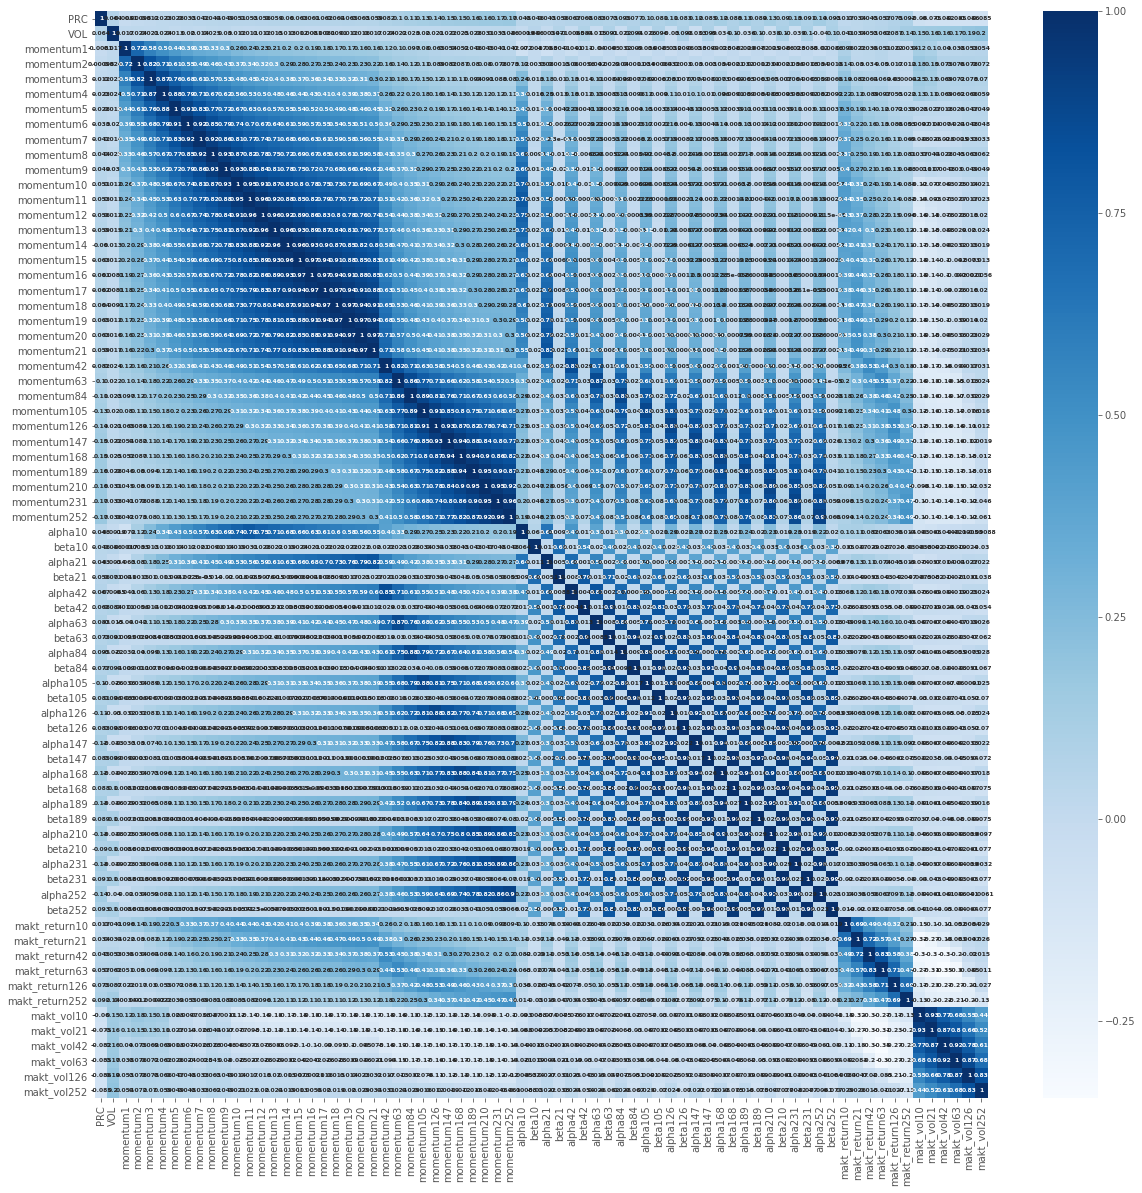

In [17]:
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)
ax = sns.heatmap(X_train[feature_all].corr(),\
                 annot=True,annot_kws={'size':6,'weight':'bold'},cmap="Blues")

# Basic Models

### Lasso

In [36]:
lasso1 = LogisticRegression(penalty='l1')
lasso1.fit(X_train, y_train)

/Users/zhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
train_pred = lasso1.predict(X_train)
(train_pred != y_train).mean()

0.492242799997096

### RF

In [36]:
rf1 = RandomForestClassifier(n_estimators=200, max_depth=30, n_jobs=-1)
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [37]:
val_pred = rf1.predict(X_val)
(val_pred != y_val).mean()

0.48206595524152934

In [51]:
prob1 = rf1.predict_proba(X_val)[:, 1]

In [52]:
top1000 = np.argsort(prob1)[::-1][:1000]
np.mean(np.array(y_val)[top1000])

0.55

In [95]:
y_val_prob = y_val_.copy()
y_val_prob['rf'] = prob1
y_val_prob

,date,CUSIP,TICKER,Yshift,rf
137547,1991-02-28,03965L10,AA,1.0,0.483555
137548,1991-02-28,60871R20,ACCOB,0.0,0.446527
137549,1991-02-28,00724F10,ADBE,0.0,0.432681
137550,1991-02-28,85812220,ADPT,1.0,0.441200
137551,1991-02-28,83088M10,AHA,1.0,0.480000
...,...,...,...,...,...
206043,2000-06-30,98742510,YNR,1.0,0.608684
206044,2000-06-30,98849810,YUM,1.0,0.421750
206045,2000-06-30,34484910,Z,0.0,0.467231
206046,2000-06-30,98920710,ZBRA,0.0,0.482073


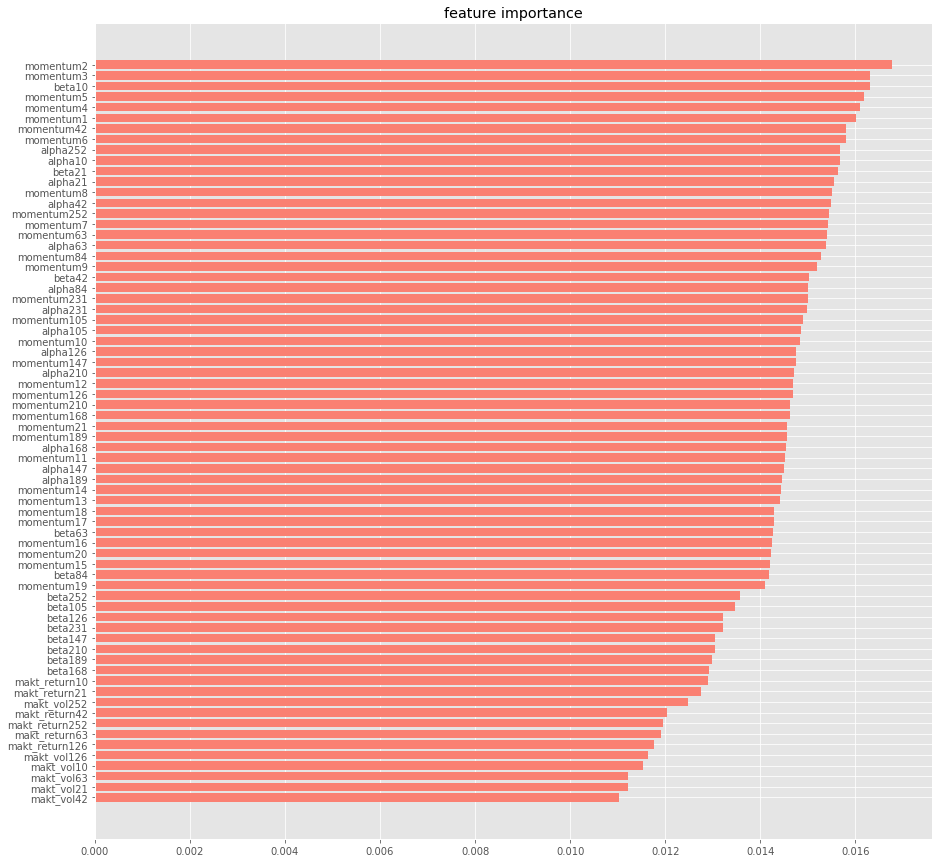

In [41]:
importances = rf1.feature_importances_
names = X_train.columns
indices = np.argsort(importances)

fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(1, 1)
plt.barh(names[indices], importances[indices],
        color='salmon', align='center')
plt.title('feature importance')
plt.show()

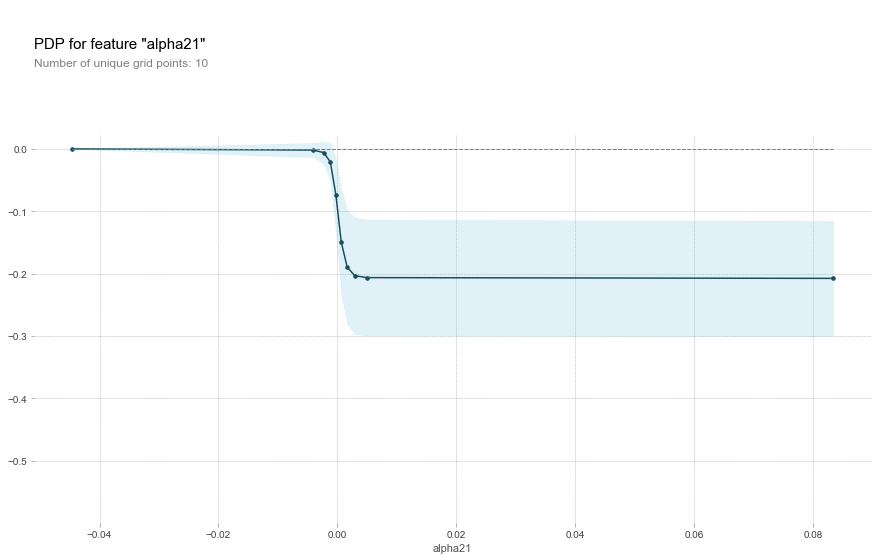

In [109]:
pdpobj = pdp.pdp_isolate(model=rf1, dataset=X_train, model_features=feature_all, feature='alpha21')
fig, axes = pdp.pdp_plot(pdpobj, 'alpha21')

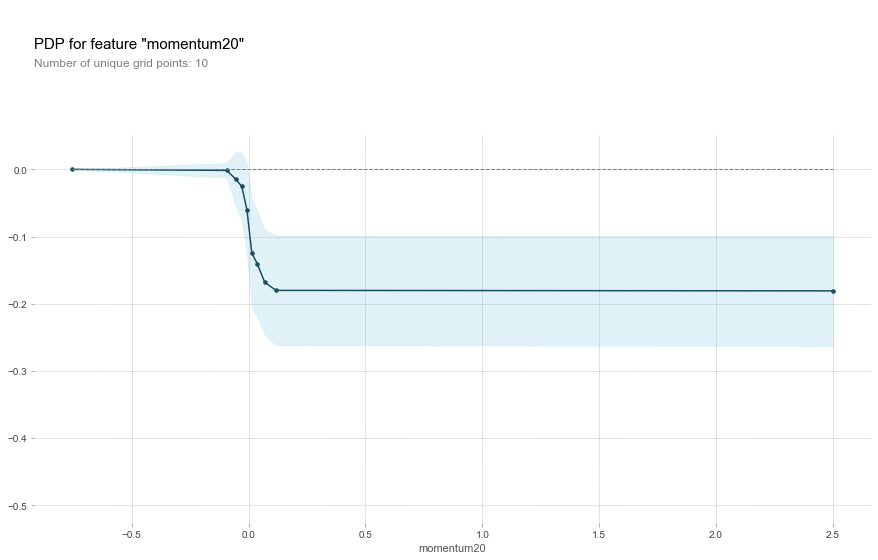

In [111]:
pdpobj = pdp.pdp_isolate(model=rf1, dataset=X_train, model_features=feature_all, feature='momentum20')
fig, axes = pdp.pdp_plot(pdpobj, 'momentum20')

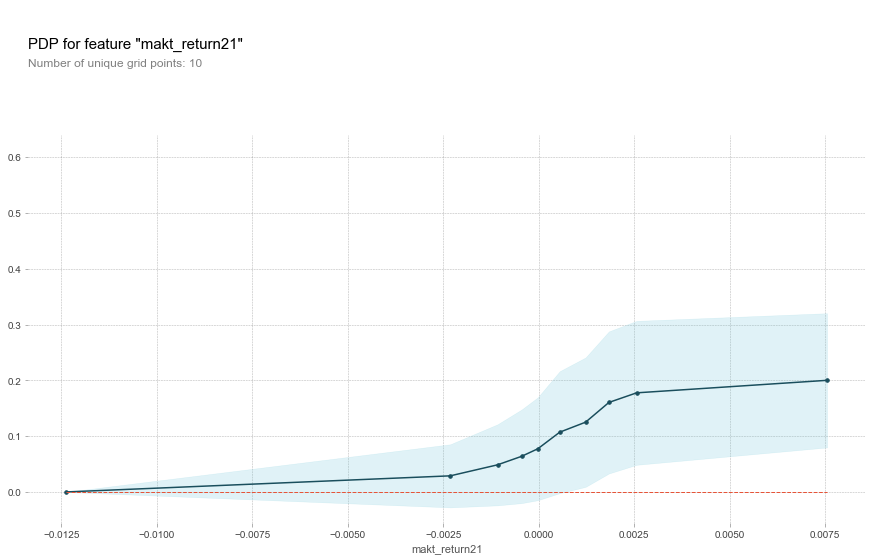

In [113]:
pdpobj = pdp.pdp_isolate(model=rf1, dataset=X_train, model_features=feature_all, feature='makt_return21')
fig, axes = pdp.pdp_plot(pdpobj, 'makt_return21')

In [74]:
prob1_ = rf1.predict_proba(X_test)[:, 1]
prob1_

array([0.52143895, 0.50264886, 0.49140442, ..., 0.48270268, 0.48725691,
       0.47493811])

In [75]:
y_test_.loc[:, 'postprob'] = prob1_

In [76]:
ind = pd.MultiIndex.from_frame(y_test_[['date', 'TICKER']], names=('date', 'TICKER'))
table = pd.DataFrame(index = ind)
table['postprob'] = prob1_

In [77]:
table

postprob
date       TICKER          
2000-07-31 AA      0.521439
           ACAS    0.502649
           ACL     0.491404
           ADBE    0.495000
           ADPT    0.510000
...                     ...
2019-11-29 YUMC    0.545170
           ZBH     0.511110
           ZBRA    0.482703
           ZION    0.487257
           ZTS     0.474938

[136542 rows x 1 columns]

In [78]:
table = pd.pivot_table(table, values='postprob', index='date', columns='TICKER')

In [70]:
table.to_csv('rf.csv')

In [101]:
param_range = np.arange(1, 100, 2)

train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

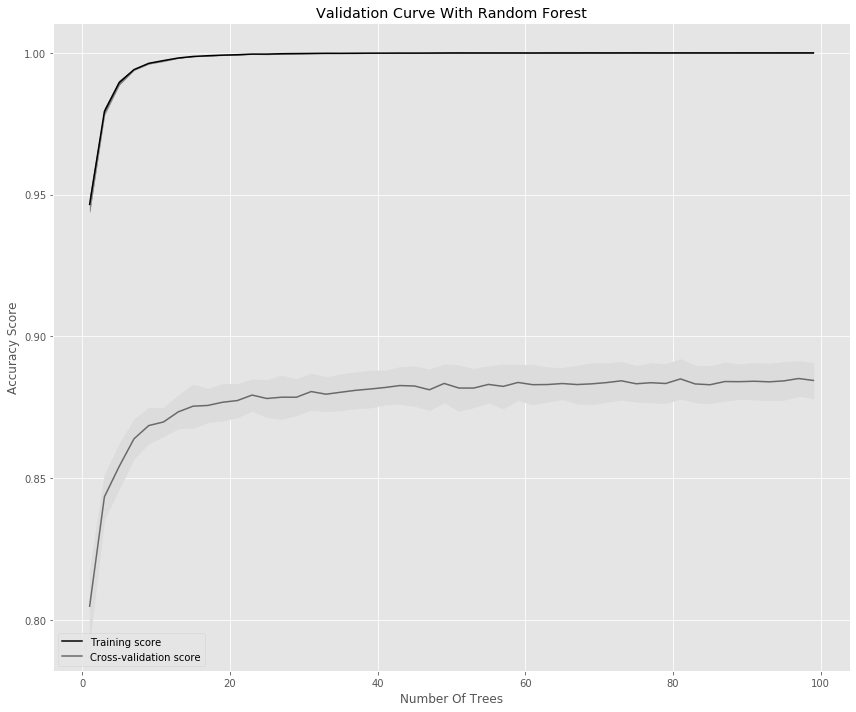

In [103]:
fig = plt.figure(figsize=(12, 10))
ax = fig.subplots(1, 1)
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

sklearn.model_selection._search.GridSearchCV

In [39]:
len(feature_all)

70

## XGBOOST

In [84]:
trainDM = xgb.DMatrix(X_train.values, y_train, feature_names=X_train.columns)
valDM = xgb.DMatrix(X_val.values, y_val, feature_names=X_val.columns)
testDM = xgb.DMatrix(X_test.values, y_test, feature_names=X_test.columns)

In [86]:
params = {
    'objective':'binary:logistic',
    'learning_rate':0.2,
    'max_depth':10,
    'eval_metric':'auc',
    'seed':0}

#xgbcv = xgb.cv(params=params, num_boost_round=400, dtrain=trainDM)

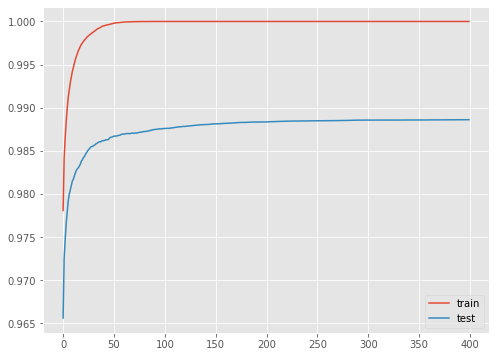

In [134]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(1, 1)
plt.plot(range(400), xgbcv['train-auc-mean'])
plt.plot(range(400), xgbcv['test-auc-mean'])
plt.legend(['train', 'test'])
plt.show()

In [135]:
idx = np.argmax(xgbcv['test-auc-mean']) + 1
print(idx)

400


In [87]:
myxgb1 = xgb.train(num_boost_round=200, dtrain=trainDM, params=params)
score1 = myxgb1.predict(valDM)
print(score1)

[0.42721292 0.3247301  0.26901796 ... 0.35916007 0.12905276 0.49456567]


In [88]:
val_pred = (score1 > 0.5)
(val_pred != y_val).mean()

0.4893651187573904

In [89]:
top1000 = np.argsort(score1)[::-1][:int(0.2 * len(score1))]
np.mean(np.array(y_val)[top1000])

0.524014598540146

In [90]:
prob2_ = myxgb1.predict(testDM)
ind = pd.MultiIndex.from_frame(y_test_[['date', 'TICKER']], names=('date', 'TICKER'))
table2 = pd.DataFrame(index = ind)
table2['postprob'] = prob2_

In [91]:
table2 = pd.pivot_table(table2, values='postprob', index='date', columns='TICKER')

In [92]:
table2

TICKER,A,AA,AAL,AAP,ABBV,ACAS,ACE,ACL,ACN,ACT,...,YNR,YRCW,YUM,YUMC,Z,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2000-07-31,NaN,0.182453,NaN,NaN,NaN,0.490358,NaN,0.608854,NaN,NaN,...,0.52037,NaN,0.710480,NaN,0.226380,NaN,0.796510,0.740532,NaN,NaN
2000-08-31,NaN,0.420592,NaN,NaN,NaN,0.481384,NaN,0.685310,NaN,NaN,...,0.47482,NaN,0.479668,NaN,0.149449,NaN,0.727254,0.734647,NaN,NaN
2000-09-29,NaN,0.575613,NaN,NaN,NaN,0.409582,NaN,0.591544,NaN,NaN,...,NaN,NaN,0.874427,NaN,0.651738,NaN,0.452792,0.624790,NaN,NaN
2000-10-31,NaN,0.862391,NaN,NaN,NaN,0.428547,NaN,0.256138,NaN,NaN,...,NaN,NaN,0.646135,NaN,0.668250,NaN,0.740718,0.618177,NaN,NaN
2000-11-30,0.412949,0.597348,NaN,NaN,NaN,0.418152,NaN,0.197661,NaN,NaN,...,NaN,NaN,0.690914,NaN,0.569865,NaN,0.410544,0.490041,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,0.559200,NaN,0.245869,0.555606,0.575767,NaN,NaN,NaN,0.661422,NaN,...,NaN,0.795826,0.605396,0.231831,NaN,0.600339,0.523263,0.193819,NaN,0.515965
2019-08-30,0.477087,NaN,0.811399,0.454069,0.478800,NaN,NaN,NaN,0.502387,NaN,...,NaN,0.763993,0.354427,0.556278,NaN,0.596639,0.541247,0.517580,NaN,0.503136
2019-09-30,0.603610,NaN,0.237503,0.534700,0.626392,NaN,NaN,NaN,0.424756,NaN,...,NaN,0.380317,0.442447,0.467556,NaN,0.473482,0.336597,0.418865,NaN,0.441448


In [93]:
table2.to_csv('boost.csv')

In [96]:
y_val_prob['boost'] = score1
y_val_prob

,date,CUSIP,TICKER,Yshift,rf,boost
137547,1991-02-28,03965L10,AA,1.0,0.483555,0.427213
137548,1991-02-28,60871R20,ACCOB,0.0,0.446527,0.324730
137549,1991-02-28,00724F10,ADBE,0.0,0.432681,0.269018
137550,1991-02-28,85812220,ADPT,1.0,0.441200,0.353425
137551,1991-02-28,83088M10,AHA,1.0,0.480000,0.324721
...,...,...,...,...,...,...
206043,2000-06-30,98742510,YNR,1.0,0.608684,0.464376
206044,2000-06-30,98849810,YUM,1.0,0.421750,0.673695
206045,2000-06-30,34484910,Z,0.0,0.467231,0.359160
206046,2000-06-30,98920710,ZBRA,0.0,0.482073,0.129053


In [97]:
y_val_prob.to_csv('postprob on val.csv')

In [115]:
param_range = np.arange(1, 100, 2)

train_scores, test_scores = validation_curve(XGBClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

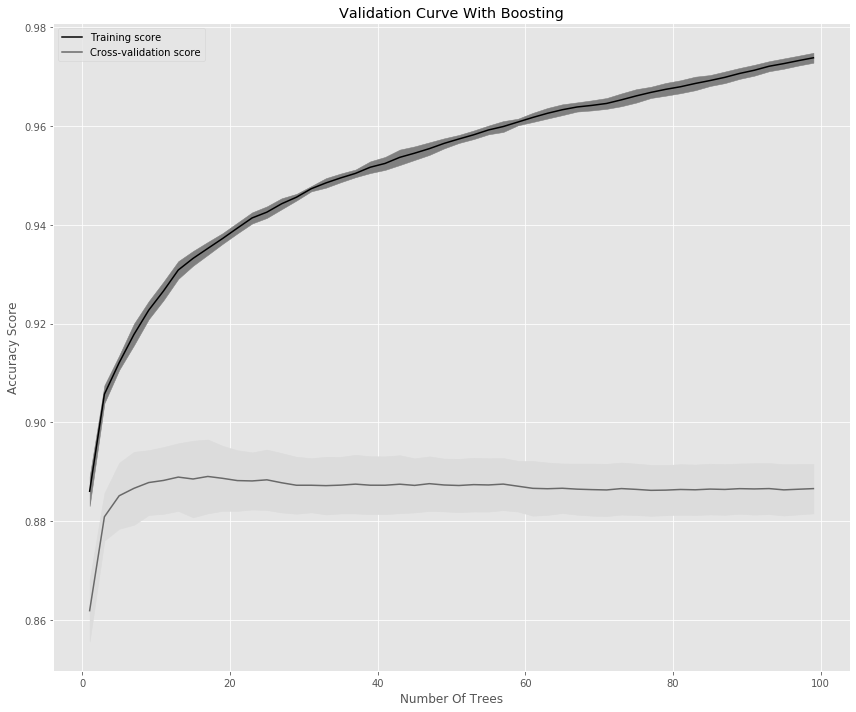

In [117]:
fig = plt.figure(figsize=(12, 10))
ax = fig.subplots(1, 1)
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Boosting")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# Neural Network

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [43]:
batch_size = 32

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(70, 300)  # 6*6 from image dimension
        self.fc2 = nn.Linear(300, 120)
        self.fc3 = nn.Linear(120, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x
    

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
dev = "cpu"
device = torch.device(dev)
net = Net()
net.to(device)
print(net)

Net(
  (fc1): Linear(in_features=70, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)


In [174]:
#data = torch.utils.data.IterableDataset(X_train)
#dir(data)
#batchsampler = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=True)

In [175]:
#for i in enumerate(batchsampler):
#    print(i)

In [44]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [45]:
for e in range(6):
    for i in tqdm.tqdm(range(n1 // batch_size)):
        x = torch.from_numpy(np.array(X_train.iloc[i*batch_size:(i+1)*batch_size, :])).to(device).float()
        out = net(x)

        optimizer.zero_grad()
        target = torch.from_numpy(np.array(y_train.iloc[i*batch_size:(i+1)*batch_size])).to(device).long()
        
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

100%|█████████████████████████████████████████████████████████████████████████████| 4298/4298 [00:08<00:00, 511.03it/s]


In [46]:
Xvaltensor = torch.from_numpy(np.array(X_val)).to(device).float()
result = net(Xvaltensor).cpu()[:, 1].detach().numpy()

In [47]:
y_pred = np.zeros(result.shape)
y_pred[(result > 0.5)] = 1
(y_pred != y_val).mean()

0.4777156537860761

In [48]:
top1000 = np.argsort(result)[::-1][:int(0.2*len(result))]
np.mean(np.array(y_val)[top1000])

0.5392700729927007

# Compute post prob

In [51]:
'''
compute post prob for each stock at each day.
'''

#date_test = X_test["date"].unique()
#ticker_test = X_test["TICKER"].unique()

post_prob = pd.DataFrame(columns=ticker_test)
for i in date_test:
    #model.predict_proba(X_test[feature_all])
    post_prob.loc[i] = 0
#post_prob

# Back test

In [20]:
# use post_prob as input 